In [33]:
bdd100k_path = "../../yolo-testing/datasets/bdd100k_night_bg"
tdnd_canada_path = "../../yolo-testing/datasets/night_only_Canada_v2"
tdnd_australia_path = "../../yolo-testing/datasets/night_Australia"
tdnd_china_path = "../../yolo-testing/datasets/night_only_China"

datasets = [
    {
        "name": "bdd100k",
        "path": bdd100k_path
    },
    {
        "name": "tdnd_canada",
        "path": tdnd_canada_path
    },
    {
        "name": "tdnd_australia",
        "path": tdnd_australia_path
    },
    {
        "name": "tdnd_china",
        "path": tdnd_china_path
    }
]

In [23]:
import glob

def check_pairs(dataset_path: str) -> None:
    print(f"Checking pairs in {dataset_path}")
    # Check if there are pairs of images and labels
    images_train = glob.glob(f"{dataset_path}/images/train/*.jpg")
    images_val = glob.glob(f"{dataset_path}/images/val/*.jpg")
    labels_train = glob.glob(f"{dataset_path}/labels/train/*.txt")
    labels_val = glob.glob(f"{dataset_path}/labels/val/*.txt")
    print(f"Images (train): {len(images_train)}")
    print(f"Images (val): {len(images_val)}")
    print(f"Labels (train): {len(labels_train)}")
    print(f"Labels (val): {len(labels_val)}")
    if len(images_train) != len(labels_train):
        print("Mismatch in train images and labels")
        for img in images_train:
            if img.replace("images", "labels").replace(".jpg", ".txt") not in labels_train:
                print(f"Missing label for {img}")
    if len(images_val) != len(labels_val):
        print("Mismatch in val images and labels")
        for img in images_val:
            if img.replace("images", "labels").replace(".jpg", ".txt") not in labels_val:
                print(f"Missing label for {img}")

for dataset in datasets:
    check_pairs(dataset["path"])

Checking pairs in ../../yolo-testing/datasets/bdd100k_night_v2
Images (train): 27971
Images (val): 3929
Labels (train): 27971
Labels (val): 3929
Checking pairs in ../../yolo-testing/datasets/night_only_Canada_v2
Images (train): 11345
Images (val): 2836
Labels (train): 11345
Labels (val): 2836
Checking pairs in ../../yolo-testing/datasets/night_Australia
Images (train): 10696
Images (val): 2487
Labels (train): 10696
Labels (val): 2487
Checking pairs in ../../yolo-testing/datasets/night_only_China
Images (train): 10893
Images (val): 2695
Labels (train): 10893
Labels (val): 2695


In [24]:

def get_background_pairs(dataset_path: str) -> list[dict]:
    """
    Get pairs of background images and labels, e.g. images with empty paired labels
    """
    labels_train = glob.glob(f"{dataset_path}/labels/train/*.txt")
    labels_val = glob.glob(f"{dataset_path}/labels/val/*.txt")
    background_pairs = []
    # Check all labels to see if the .txt file is empty
    for label in labels_train:
        with open(label, "r") as f:
            content = f.read()
            if content == "":
                background_pairs.append({
                    "image": label.replace("labels", "images").replace(".txt", ".jpg"),
                    "label": label
                })
    for label in labels_val:
        with open(label, "r") as f:
            content = f.read()
            if content == "":
                background_pairs.append({
                    "image": label.replace("labels", "images").replace(".txt", ".jpg"),
                    "label": label
                })
    return background_pairs

for dataset in datasets:
    print(f"Background pairs in {dataset['name']}")
    background_pairs = get_background_pairs(dataset["path"])
    print(f"Background pairs: {len(background_pairs)}")

Background pairs in bdd100k
Background pairs: 140
Background pairs in tdnd_canada
Background pairs: 5832
Background pairs in tdnd_australia
Background pairs: 6672
Background pairs in tdnd_china
Background pairs: 893


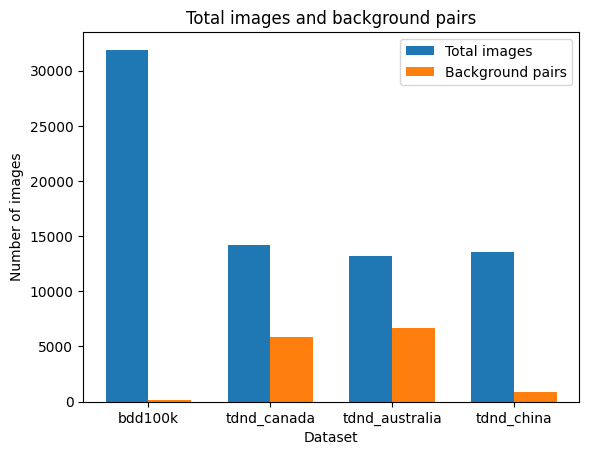

In [25]:
# Plot all the background pairs as bars in the same plot
import matplotlib.pyplot as plt

def plot_background_pairs(total_num: tuple, background_num: tuple, dataset_name: tuple) -> None:
    """Plot total and number of background pairs for each dataset"""
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = range(len(dataset_name))
    ax.bar(index, total_num, bar_width, label="Total images")
    ax.bar([i + bar_width for i in index], background_num, bar_width, label="Background pairs")
    ax.set_xlabel("Dataset")
    ax.set_ylabel("Number of images")
    ax.set_title("Total images and background pairs")
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(dataset_name)
    ax.legend()
    plt.show()


total_images = [len(glob.glob(f"{dataset['path']}/images/train/*.jpg")) + len(glob.glob(f"{dataset['path']}/images/val/*.jpg")) for dataset in datasets]
background_pairs_num = [len(get_background_pairs(dataset["path"])) for dataset in datasets]
dataset_names = [dataset["name"] for dataset in datasets]
plot_background_pairs(total_images, background_pairs_num, dataset_names)



In [27]:
all_background_pairs = []
for dataset in datasets:
    all_background_pairs.extend(get_background_pairs(dataset["path"]))
print(f"Total background pairs: {len(all_background_pairs)}")

# train/val ratio bdd100k
images_train = glob.glob(f"{bdd100k_path}/images/train/*.jpg")
images_val = glob.glob(f"{bdd100k_path}/images/val/*.jpg")
ratio = len(images_train) / len(images_val)
print(f"Train/val ratio bdd100k: {len(images_train) / len(images_val)}")

# copy all background pairs to bdd100k training and val folder with same ratio
import shutil
import os

def copy_background_pairs(background_pairs: list[dict], target_path: str, ratio: float) -> None:
    num_val = int(len(background_pairs) / (ratio + 1))
    num_train = len(background_pairs) - num_val
    print(f"Copying {num_train} background pairs to train folder")
    print(f"Copying {num_val} background pairs to val folder")
    for i in range(num_train):
        pair = background_pairs[i]
        try:
            shutil.copy(pair["image"], f"{target_path}/images/train")
            shutil.copy(pair["label"], f"{target_path}/labels/train")
        except shutil.SameFileError:
            print(f"File {pair['image']} already exists in train folder")
            print(f"File {pair['label']} already exists in train folder")
    print(f"Copying {num_val} background pairs to val folder")
    for i in range(num_train, num_train + num_val):
        pair = background_pairs[i]
        # check existence of files
        try:
            shutil.copy(pair["image"], f"{target_path}/images/val")
            shutil.copy(pair["label"], f"{target_path}/labels/val")
        except shutil.SameFileError:
            print(f"File {pair['image']} already exists in val folder")
            print(f"File {pair['label']} already exists in val folder")

copy_background_pairs(all_background_pairs, bdd100k_path, ratio)

Total background pairs: 13537
Train/val ratio bdd100k: 7.119114278442352
Copying 11870 background pairs to train folder
Copying 1667 background pairs to val folder
File ../../yolo-testing/datasets/bdd100k_night_v2/images/train/2d62a90a-88e46003.jpg already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/labels/train/2d62a90a-88e46003.txt already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/images/train/a42a9ba1-7f67ddaf.jpg already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/labels/train/a42a9ba1-7f67ddaf.txt already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/images/train/4170f5e5-367f209f.jpg already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/labels/train/4170f5e5-367f209f.txt already exists in train folder
File ../../yolo-testing/datasets/bdd100k_night_v2/images/train/605434f1-0a21dcef.jpg already exists in train folder
File ../../yolo-testing/

[13556, 5832, 6672, 893]


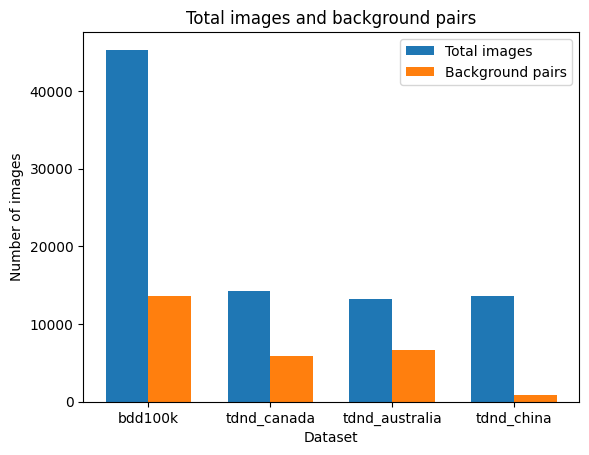

In [34]:
# verify that the background pairs are copied
total_images = [len(glob.glob(f"{dataset['path']}/images/train/*.jpg")) + len(glob.glob(f"{dataset['path']}/images/val/*.jpg")) for dataset in datasets]
background_pairs_num = [len(get_background_pairs(dataset["path"])) for dataset in datasets]
dataset_names = [dataset["name"] for dataset in datasets]
print(background_pairs_num)
plot_background_pairs(total_images, background_pairs_num, dataset_names)


In [ ]:
bdd100k_path = "../../yolo-testing/datasets/bdd100k_night_bg"
# Check number of training images and val in bdd100k
images_train = glob.glob(f"{bdd100k_path}/images/train/*.jpg")
images_val = glob.glob(f"{bdd100k_path}/images/val/*.jpg")
print(f"Total images bdd100k: {len(images_train) + len(images_val)}")
print(f"Images bdd100k (train): {len(images_train)}")
print(f"Images bdd100k (val): {len(images_val)}")

# Check number of labels in bdd100k
labels_train = glob.glob(f"{bdd100k_path}/labels/train/*.txt")
labels_val = glob.glob(f"{bdd100k_path}/labels/val/*.txt")
print(f"Total labels bdd100k: {len(labels_train) + len(labels_val)}")
print(f"Labels bdd100k (train): {len(labels_train)}")
print(f"Labels bdd100k (val): {len(labels_val)}")

Total images bdd100k: 45316
Images bdd100k (train): 39720
Images bdd100k (val): 5596
Total labels bdd100k: 45316
Labels bdd100k (train): 39720
Labels bdd100k (val): 5596
